# 环境准备

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prophet

# 设置pandas可以显示的行数和列数
pd.options.display.max_rows = 400
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")

#推荐安装插件： nbextensions

# 读入数据

In [2]:
# sales_detail 
## date: 日期
## store_id: 门店编号
## sales: 营业额
data = pd.read_csv('data/sales_data_detail.csv', parse_dates=['date'])
data.head(2)

,store_id,date,sales
0,1,2015-04-01,275765.184075
1,1,2015-04-02,255256.272380


In [3]:
# 门店编号
data['store_id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

# EDA - 探索性数据分析 （exploratory data analysis)

## 是否有异常值

In [4]:
data.describe()

,store_id,sales
count,11314.000000,1.131400e+04
mean,6.767191,4.493729e+05
std,3.679010,5.606483e+05
min,1.000000,1.649694e+03
25%,4.000000,1.540502e+04
50%,7.000000,2.568751e+05
75%,10.000000,6.914913e+05
max,14.000000,2.736065e+06


## 是否有缺失值

In [5]:
# 是否有na值
data[ data['sales'].isna() ].shape[0]

0

In [6]:
# 是否每天都有数据
date_begin = data['date'].min()
date_end = data['date'].max()
date_count = len( data['date'].unique() )

date_miss = (date_end - date_begin).days + 1 - date_count
print( date_miss )

0


In [7]:
# 是否每家门店每天都有数据
store_date_range = data.groupby(['store_id'])['date'].agg(['min','max','nunique']).reset_index()
store_date_range.columns = ['store_id', 'date_begin', 'date_end', 'date_count']
store_date_range['date_miss'] = (store_date_range['date_end']-store_date_range['date_begin']
                                 ).dt.days + 1 - store_date_range['date_count']
store_date_range.describe()

,store_id,date_count,date_miss
count,14.0000,14.000000,14.0
mean,7.5000,808.142857,0.0
std,4.1833,374.347814,0.0
min,1.0000,120.000000,0.0
25%,4.2500,493.250000,0.0
50%,7.5000,1065.000000,0.0
75%,10.7500,1065.000000,0.0
max,14.0000,1065.000000,0.0


## 时间序列分析： 趋势、季节性/周期性、外部变量、残差

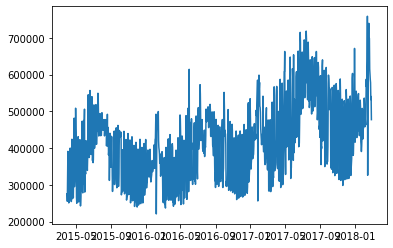

In [8]:
# 以1家店为例
data_sample = data[ data['store_id']==1 ]
plt.plot( data_sample['date'], data_sample['sales'] )

### 判断时间序列是否存在周期性

ACF检验 (Auto-Correlation Function, 自相关系数检验） 
$$ r_h = Cor( X_t, X_{t+h} ) , \forall t$$
如果$ r_h>0 $，则数据可能存在以h为单位的周期性

In [9]:
from  statsmodels.graphics.tsaplots import plot_acf

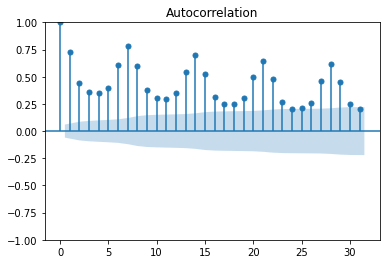

In [10]:
plot_acf(data_sample['sales'] ).show()

In [11]:
# 为了查看数据是否有更高颗粒度的周期性，先把数据按周汇总
data['week'] = data['date'] - pd.to_timedelta( data['date'].dt.weekday, unit='D' )
data_weekly = data.groupby(['week'])['sales'].mean().reset_index()

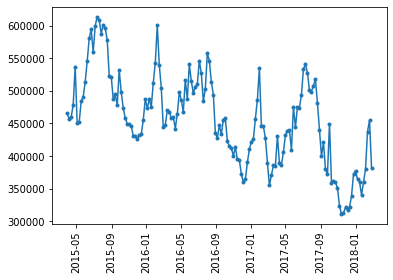

In [12]:
plt.plot( data_weekly['week'], data_weekly['sales'], '.-')
plt.xticks(rotation=90)
plt.show()

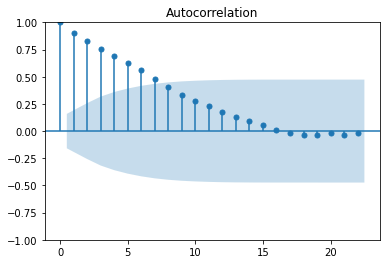

In [13]:
plot_acf( data_weekly['sales'] ).show()

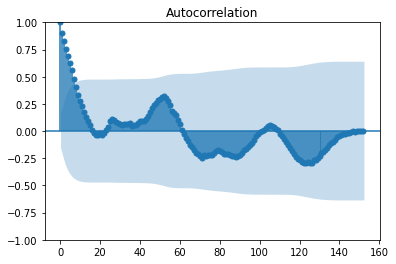

In [14]:
plot_acf( data_weekly['sales'], lags=152 ).show()
# lags=152: 检验h为1-152的相关性系数

### 用prophet将时间序列进行分解

In [15]:
# 要使用Prophet前， 需要将时间字段重命名成'ds'， 将目标变量重命名为'y'
data_sample.rename(columns={'date':'ds',
                           'sales':'y'}, inplace=True)

In [16]:
#构建一个具备同时有年间和周间周期性的模型
m = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True)

In [17]:
# 用模型拟合历史数据
m.fit( data_sample )
data_fitted = m.predict( data_sample )

22:53:48 - cmdstanpy - INFO - Chain [1] start processing
22:53:49 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
#拟合结果
## trend、trend_upper、trend_lower: 趋势、趋势的置信区间上限、趋势的置信区间下限
## weekly、weekly_upper、weekly_lower: weekly周期性、weekly周期性上限、weekly周期性下限
## yearly、yearly_upper、yearly_lower: yearly周期性、yearly周期性上限、yearly周期性下限
## yhat=trend+weekly+yearly, 即时间序列的拟合结果
data_fitted.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-04-01,362221.785903,220965.809909,357184.731258,362221.785903,362221.785903,-73556.715401,-73556.715401,-73556.715401,-36866.941126,-36866.941126,-36866.941126,-36689.774275,-36689.774275,-36689.774275,0.0,0.0,0.0,288665.070501
1,2015-04-02,362224.954222,219843.082738,348997.208215,362224.954222,362224.954222,-76598.872053,-76598.872053,-76598.872053,-38621.109264,-38621.109264,-38621.109264,-37977.762789,-37977.762789,-37977.762789,0.0,0.0,0.0,285626.082169


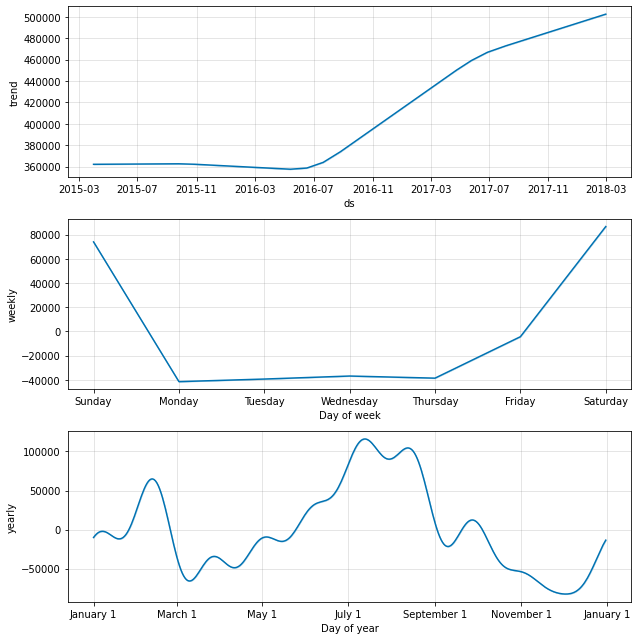

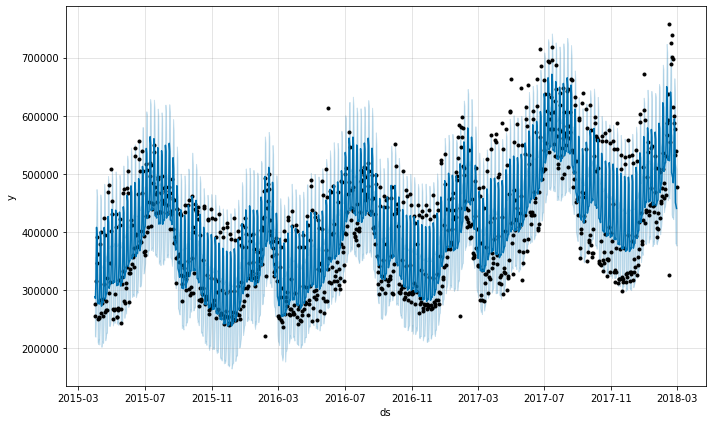

In [19]:
# 可视化
fig1 = m.plot_components(data_fitted)
fig2 = m.plot( data_fitted )

### 分析残差项

In [20]:
data_sample['yhat'] = data_fitted['yhat']
data_sample['resid'] = data_sample['y'] - data_sample['yhat']
data_sample['percentage_resid'] = abs( data_sample['resid'] )/data_sample['y']

In [21]:
data_sample.sort_values(['percentage_resid'], ascending=False).head(3)

,store_id,ds,y,yhat,resid,percentage_resid
312,1,2016-02-07,220997.823154,487022.157559,-266024.334405,1.203742
667,1,2017-01-27,256209.012393,421755.119880,-165546.107486,0.646137
1051,1,2018-02-15,326075.724520,522530.511376,-196454.786856,0.602482


In [22]:
# 添加“除夕”作为外部变量
data_sample['chuxi'] = 0
data_sample.loc[ data_sample['ds'].isin(['2016-02-07', '2017-01-27','2018-02-15']),
               'chuxi'] = 1

In [23]:
#在模型中添加外部变量的影响，重新拟合历史数据
m = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.add_regressor( 'chuxi' )
m.fit( data_sample )

data_fitted = m.predict( data_sample )
data_fitted.head(2)
# chuxi: 除夕对sales的影响

22:53:52 - cmdstanpy - INFO - Chain [1] start processing
22:53:52 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,chuxi,chuxi_lower,chuxi_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-04-01,362037.490800,218108.716997,353955.359099,362037.490800,362037.490800,-74551.464664,-74551.464664,-74551.464664,0.0,0.0,0.0,0.0,0.0,0.0,-37483.196258,-37483.196258,-37483.196258,-37068.268405,-37068.268405,-37068.268405,0.0,0.0,0.0,287486.026136
1,2015-04-02,362046.972783,218681.117351,350648.180670,362046.972783,362046.972783,-76212.082310,-76212.082310,-76212.082310,0.0,0.0,0.0,0.0,0.0,0.0,-37790.658846,-37790.658846,-37790.658846,-38421.423464,-38421.423464,-38421.423464,0.0,0.0,0.0,285834.890473


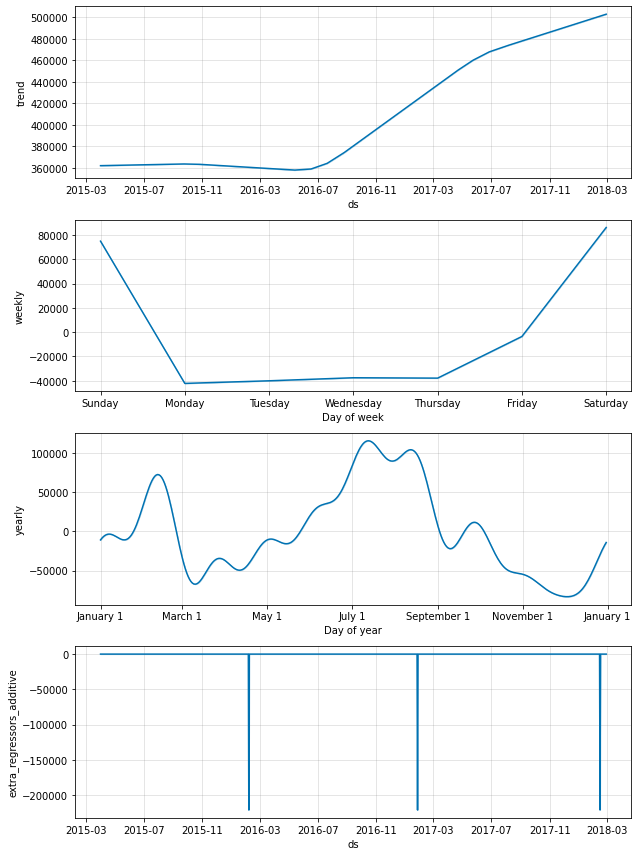

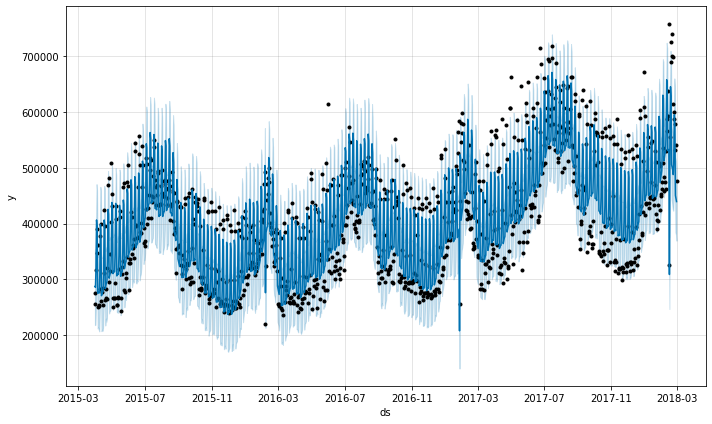

In [24]:
# 可视化
fig1 = m.plot_components(data_fitted)
fig2 = m.plot( data_fitted )

结论：
1. sales数据有很强的以年为单位和以周为单位的周期性
2. sales数据存在趋势的变化
3. 除夕对sales有很大的影响， 是个重要的外部变量

# 用prophet进行预测

用2018年1月31日前的数据训练模型，预测2018年2月1日-28日的数据

## 小样本测试

In [25]:
data_train = data_sample[ data_sample['ds']<='2018-01-31' ]
data_test = data_sample[ (data_sample['ds']>='2018-02-01') & 
                       (data_sample['ds']<='2018-02-28' )]

In [26]:
#拟合历史数据
m = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.add_regressor( 'chuxi' )
m.fit( data_train )

22:53:55 - cmdstanpy - INFO - Chain [1] start processing
22:53:55 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
# 预测未来的数据
data_predict = m.predict( data_test )

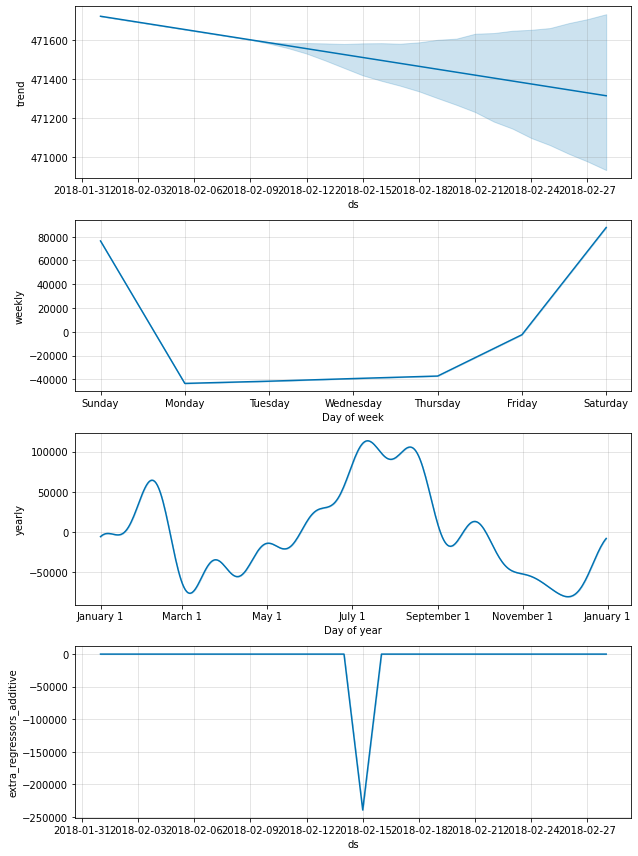

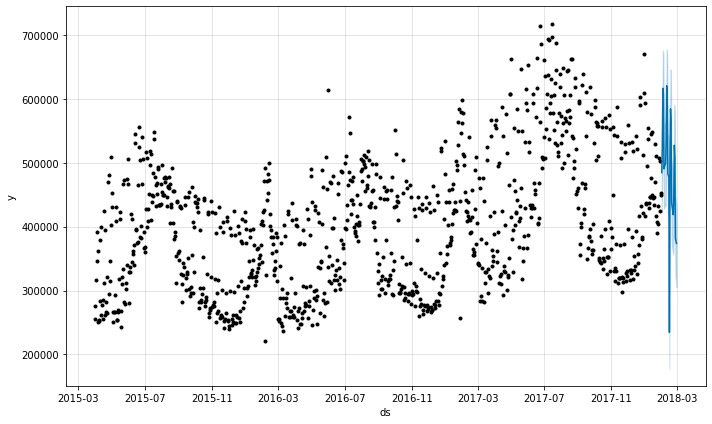

In [28]:
# 可视化
fig1 = m.plot_components(data_predict)
fig2 = m.plot( data_predict )

In [29]:
# 计算预测误差
data_test['yhat'] = data_predict['yhat'].values
data_test['perror'] = abs(data_test['yhat'] - data_test['y'])/data_test['y']

data_test['perror'].describe()

count    28.000000
mean      0.184943
std       0.122987
min       0.002622
25%       0.075961
50%       0.168407
75%       0.281539
max       0.408040
Name: perror, dtype: float64

## 对所有样本都进行测试

In [30]:
total_test_result = []

#对门店进行循环
for store_id in data['store_id'].unique():
    ## 获取一家店的数据
    data_sample = data[ data['store_id']==store_id 
                      ].rename(columns={'date':'ds',
                                       'sales':'y'})

    ## 添加“除夕”作为外部变量
    data_sample['chuxi'] = 0
    data_sample.loc[ data_sample['ds'].isin(['2016-02-07', '2017-01-27','2018-02-15']),
                    'chuxi'] = 1
    
    ## 区分训练集和测试集
    data_train = data_sample[ data_sample['ds']<='2018-01-31' ]
    data_test = data_sample[ (data_sample['ds']>='2018-02-01') & 
                            (data_sample['ds']<='2018-02-28' )]
    
    #拟合历史数据
    m = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True)
    m.add_regressor( 'chuxi' )
    m.fit( data_train )
    
    # 预测未来的数据
    data_predict = m.predict( data_test )
    
    # 计算预测误差，并且保留结果
    data_test['yhat'] = data_predict['yhat'].values
    data_test['error'] = data_test['yhat'] - data_test['y']
    total_test_result.append( data_test )
total_test_result = pd.concat( total_test_result )

22:53:58 - cmdstanpy - INFO - Chain [1] start processing
22:53:58 - cmdstanpy - INFO - Chain [1] done processing
22:53:59 - cmdstanpy - INFO - Chain [1] start processing
22:53:59 - cmdstanpy - INFO - Chain [1] done processing
22:54:00 - cmdstanpy - INFO - Chain [1] start processing
22:54:00 - cmdstanpy - INFO - Chain [1] done processing
22:54:02 - cmdstanpy - INFO - Chain [1] start processing
22:54:02 - cmdstanpy - INFO - Chain [1] done processing
22:54:03 - cmdstanpy - INFO - Chain [1] start processing
22:54:03 - cmdstanpy - INFO - Chain [1] done processing
22:54:04 - cmdstanpy - INFO - Chain [1] start processing
22:54:05 - cmdstanpy - INFO - Chain [1] done processing
22:54:06 - cmdstanpy - INFO - Chain [1] start processing
22:54:06 - cmdstanpy - INFO - Chain [1] done processing
22:54:07 - cmdstanpy - INFO - Chain [1] start processing
22:54:07 - cmdstanpy - INFO - Chain [1] done processing
22:54:09 - cmdstanpy - INFO - Chain [1] start processing
22:54:09 - cmdstanpy - INFO - Chain [1]

## 误差分析

In [31]:
## 计算百分比误差
total_test_result['perror'] = abs( total_test_result['y']-total_test_result['yhat'] )/total_test_result['y']

### 哪些日期表现得特别差

In [32]:
error_by_date = total_test_result.groupby(['ds'])['perror'].mean().reset_index()

error_by_date.sort_values(['perror'], ascending=False)

,ds,perror
27,2018-02-28,3.594644
26,2018-02-27,2.979656
25,2018-02-26,2.901413
14,2018-02-15,2.445645
24,2018-02-25,2.325768
23,2018-02-24,2.137277
22,2018-02-23,2.048141
21,2018-02-22,1.906178
20,2018-02-21,1.574337
19,2018-02-20,1.445425


22:54:17 - cmdstanpy - INFO - Chain [1] start processing
22:54:17 - cmdstanpy - INFO - Chain [1] done processing


(array([17563., 17567., 17571., 17575., 17579., 17583., 17587., 17591.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

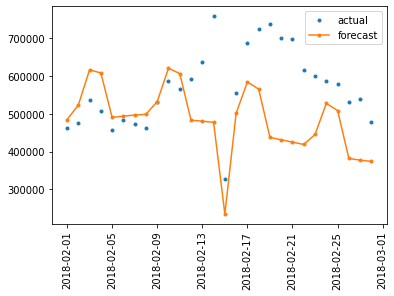

In [33]:
# 以1号门店为例，单独可视化它的拟合和预测结果
data_sample = data[ data['store_id']==1 
                  ].rename(columns={'date':'ds',
                                    'sales':'y'})

## 添加“除夕”作为外部变量
data_sample['chuxi'] = 0
data_sample.loc[ data_sample['ds'].isin(['2016-02-07', '2017-01-27','2018-02-15']),
                'chuxi'] = 1
    
## 区分训练集和测试集
data_train = data_sample[ data_sample['ds']<='2018-01-31' ]
data_test = data_sample[ (data_sample['ds']>='2018-02-01') & 
                        (data_sample['ds']<='2018-02-28' )]
    
#拟合历史数据
m = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.add_regressor( 'chuxi' )
m.fit( data_train )


# 预测未来的数据
data_predict = m.predict( data_test )
data_test['yhat'] = data_predict['yhat'].values


# 可视化预测结果
plt.plot( data_test['ds'], data_test['y'], '.', label='actual' )
plt.plot( data_test['ds'], data_test['yhat'], '.-', label='forecast' )
plt.legend()
plt.xticks(rotation=90)

22:54:19 - cmdstanpy - INFO - Chain [1] start processing
22:54:19 - cmdstanpy - INFO - Chain [1] done processing


(array([17563., 17567., 17571., 17575., 17579., 17583., 17587., 17591.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

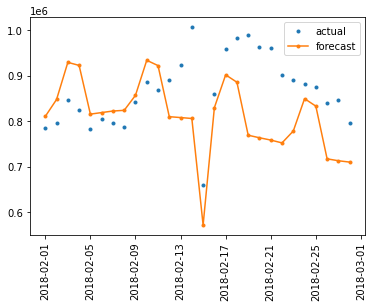

In [34]:
# 以2号门店为例，单独可视化它的拟合和预测结果
data_sample = data[ data['store_id']==2 
                  ].rename(columns={'date':'ds',
                                    'sales':'y'})

## 添加“除夕”作为外部变量
data_sample['chuxi'] = 0
data_sample.loc[ data_sample['ds'].isin(['2016-02-07', '2017-01-27','2018-02-15']),
                'chuxi'] = 1
    
## 区分训练集和测试集
data_train = data_sample[ data_sample['ds']<='2018-01-31' ]
data_test = data_sample[ (data_sample['ds']>='2018-02-01') & 
                        (data_sample['ds']<='2018-02-28' )]
    
#拟合历史数据
m = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.add_regressor( 'chuxi' )
m.fit( data_train )


# 预测未来的数据
data_predict = m.predict( data_test )
data_test['yhat'] = data_predict['yhat'].values


# 可视化预测结果
plt.plot( data_test['ds'], data_test['y'], '.', label='actual' )
plt.plot( data_test['ds'], data_test['yhat'], '.-', label='forecast' )
plt.legend()
plt.xticks(rotation=90)

**结论**
1. 预测结果普遍偏低， 说明还有优化空间
2. 可以通过调整Prophet的参数来优化 m= prophet.Prophet( *params) 


**可调整的超参数**

* changepoint_prior_scale: 这可能是影响最大的参数。它决定了趋势的灵活性，特别是趋势变化点的趋势变化程度。如果它太小，趋势将被欠拟合。如果太大，趋势将过度拟合。0.05的默认值适用于许多时间序列，但可以进行调整；[0.001, 0.5]的范围可能是正确的。



* seasonality_prior_scale: 这控制了拟合季节性效应的灵活性。大值可以让季节性适应大的波动，小值可以缩小季节性的幅度。默认值是10.。一个合理的调整范围可能是[0.01，10]。


* holidays_prior_scale: 这控制了拟合假日效应的灵活性。作用与seasonality_prior_scale 类似，它的默认值是 10.0，也可以像季节性_prior_scale那样在[0.01, 10]的范围内进行调整。


* seasonality_mode: 选项为['additive', 'multiplicative']。默认值是 'additive'，但许多商业时间序列将具有多重季节性。最好的办法是通过观察时间序列，看季节性波动的幅度是否随时间序列的幅度而增长，但如果无法做到这一点，可以对其进行调整。

**也许可以调整的超参数**

* changepoint_range: 这是历史情况上允许趋势变化的比例，默认为0.8，即历史的80%，这意味着模型不会拟合时间序列最后20%的趋势变化。所以，这个参数可能最好不要调整，除非可能是在大量的时间序列上，在这种情况下，[0.8，0.95]可能是一个合理的范围。

**基本不用调整的超参数**

* growth: 选项是 "logistic "、 "linear"和'flat'。这很可能可以根据对业务的理解定下来，不需要被调整：如果有一个已知的上限或下限，可以用'logistic';如果没有上升或下降的趋势，用“flat";否则用'linear'。


* changepoints: 用于手动指定变更点的位置。如果有业务知识，可以制定变更点；否则留空。


* n_changepoints: 变化点的数量。默认的25个应该足以捕捉典型时间序列的趋势变化。与其增加或减少变化点的数量，不如专注于增加或减少这些趋势变化的灵活性，这可能会更有效，这可以通过changepoint_prior_scale来实现。


* yearly_seasonality: 选项是['auto', True, False]。如果有超过一年的数据，建议开启，并通过调整seasonality_prior_scale来调整季节性影响。默认情况下('auto')，如果有一年的数据，将开启年度季节性，否则关闭。


* weekly_seasonality: 和 yearly_seasonality 一样。


* daily_seasonality:和 yearly_seasonality 一样


* holidays: 这是为了传递一个指定假期的dataframe。


* mcmc_samples: 是否需要对季节性进行区间预测。


* interval_width: Prophet predict返回每个分量的不确定性区间，如预测yhat的yhat_lower和yhat_upper。默认的0.8提供了80%的预测区间。如果你想要95%的区间，可以改成0.95。这将只影响不确定性区间，根本不会改变预测yhat，因此不需要调整。


* stan_backend: 如果同时设置了pystan和cmdstanpy set up,，可以指定后台。预测会是一样的，这个不会被调整。

### 哪些门店表现的特别差

In [35]:
error_by_store = total_test_result.groupby(['store_id'])['perror'].mean().reset_index()
error_by_store.sort_values(['perror'], ascending=False)

,store_id,perror
12,13,14.022905
3,4,0.301789
11,12,0.298825
7,8,0.270414
13,14,0.269252
2,3,0.266067
6,7,0.251449
9,10,0.200134
0,1,0.184943
5,6,0.152613


22:54:20 - cmdstanpy - INFO - Chain [1] start processing
22:54:21 - cmdstanpy - INFO - Chain [1] done processing


(array([17563., 17567., 17571., 17575., 17579., 17583., 17587., 17591.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

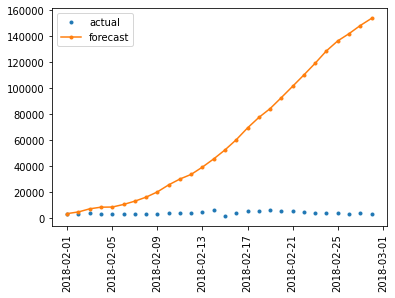

In [36]:
# 13号门店表现得特别差，单独可视化它的拟合和预测结果
data_sample = data[ data['store_id']==13 
                  ].rename(columns={'date':'ds',
                                    'sales':'y'})

## 添加“除夕”作为外部变量
data_sample['chuxi'] = 0
data_sample.loc[ data_sample['ds'].isin(['2016-02-07', '2017-01-27','2018-02-15']),
                'chuxi'] = 1
    
## 区分训练集和测试集
data_train = data_sample[ data_sample['ds']<='2018-01-31' ]
data_test = data_sample[ (data_sample['ds']>='2018-02-01') & 
                        (data_sample['ds']<='2018-02-28' )]
    
#拟合历史数据
m = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.add_regressor( 'chuxi' )
m.fit( data_train )


# 预测未来的数据
data_predict = m.predict( data_test )
data_test['yhat'] = data_predict['yhat'].values


# 可视化预测结果
plt.plot( data_test['ds'], data_test['y'], '.', label='actual' )
plt.plot( data_test['ds'], data_test['yhat'], '.-', label='forecast' )
plt.legend()
plt.xticks(rotation=90)

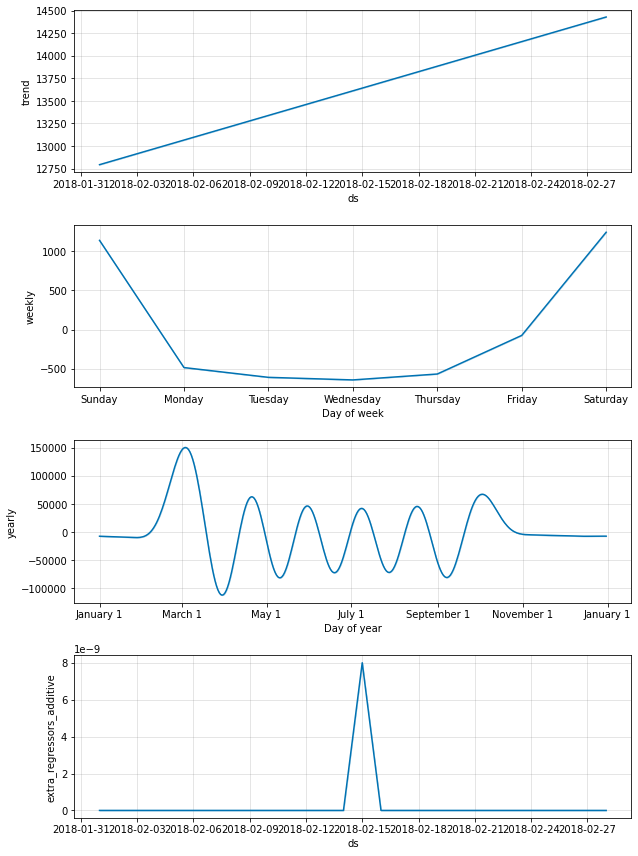

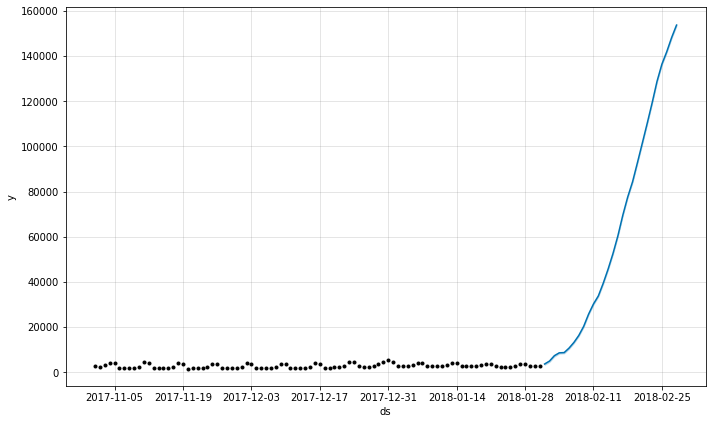

In [37]:
# 可视化预测过程
fig1 = m.plot_components(data_predict)
fig2 = m.plot( data_predict )

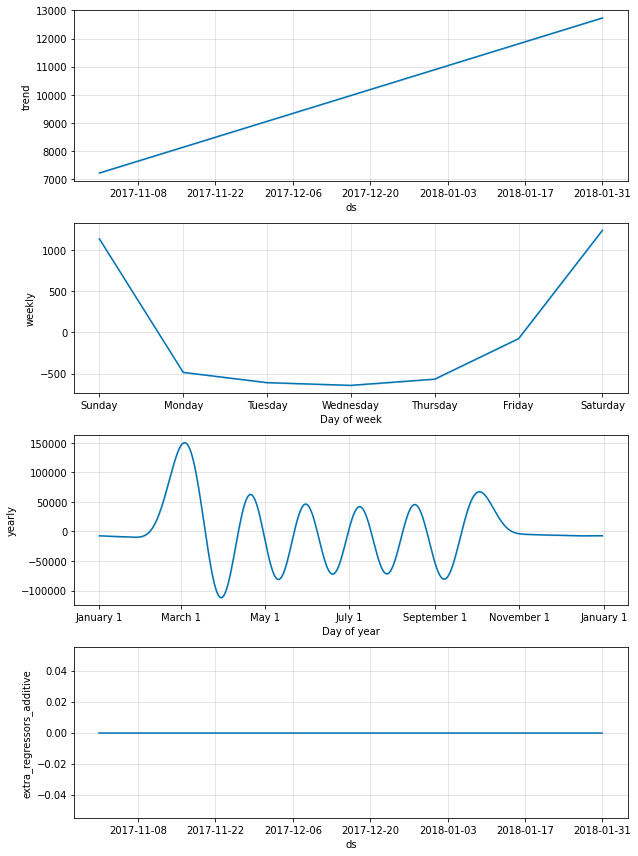

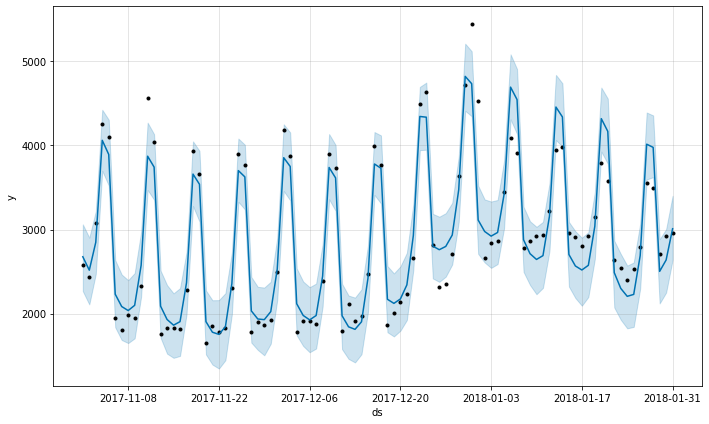

In [38]:
# 拟合历史数据
data_fitted = m.predict( data_train )

# 可视化拟合结果
fig1 = m.plot_components(data_fitted)
fig2 = m.plot( data_fitted )

结论：
* 13号门店的历史数据不足一年，所以Prophet无法正确拟合出yearly的周期性以及trend
* 为了解决这个问题，我们可以引入深度学习算法 （比如deepAR)